## Introduction

The idea of developing a computer system capable of recognizing birds was considered extremely difficult in 2015, so much so that it was the inspiration for an [XKCD joke](https://xkcd.com/1425/).

I want to make a bird detector that works fairly reliably with any sort of input image.

A <span title="A multi-label classifier is a type of machine learning model that can assign multiple labels or categories to an input instance simultaneously. For example, we may have an image with both a bird and a cat, and an image without any animal.">multi-label classifier</span> for birds, cats, and dogs should be a good starting point.

![](attachment:f228cadf-4f0f-4be0-b030-f9b2e8729b0c.png "In the 60s, Marvin Minsky assigned a couple of undergrads to spend the summer programming a computer to use a camera to identify objects in a scene. He figured they'd have the problem solved by the end of the summer. Half a century later, we're still working on it.")
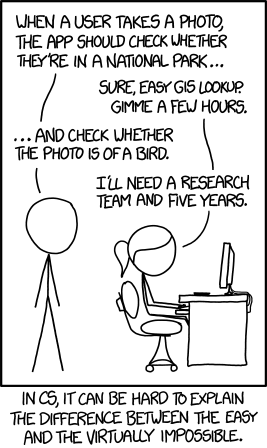

It's going to take me a lot more than 5 minutes to make a good bird detector, but hopefully I won't need to hire a research team for five years!

These are my main references:

- [Practical Deep Learning for Coders, 2022 edition, lesson 0: Is it a bird?](https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb)
- [The FastAI book, chapter 6](https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb)
- [Walk with FastAI Revisited](https://store.walkwithfastai.com/walk-with-fastai-revisited):
  - [lesson 3 notebook - multilabel](https://github.com/muellerzr/Walk-with-fastai-revisited/blob/main/03_multilabel.ipynb)
  - [lesson 3a notebook - unknown label](https://github.com/muellerzr/Walk-with-fastai-revisited/blob/main/03a_unknown.ipynb)
  - [lesson 5 notebook - deployment with fastai](https://github.com/muellerzr/Walk-with-fastai-revisited/blob/main/05_deployment_with_fastai.ipynb)
  - [lesson 5a notebook - deployment without fastai](https://github.com/muellerzr/Walk-with-fastai-revisited/blob/main/05a_deployment_no_fastai.ipynb)

After doing maybe half of the work for this project, I found that it will be too much for a single blog post, so I've split it up into eight posts:

1. [collecting images](/posts/multilabel1/multilabel1.html)
2. [reusable functions](/posts/multilabel2/multilabel2.html)
3. [Google image search](/posts/multilabel3/multilabel3.html)
4. [cleaning up the dataset](/posts/multilabel4/multilabel4.html)
5. [finding duplicate images](/posts/multilabel5/multilabel5.html)
6. [training the model](/posts/multilabel6/multilabel6.html)
7. [deploying with fastai](/posts/multilabel7/multilabel7.html)
8. [deploying without fastai](/posts/multilabel8/multilabel8.html)

## Highlight text having mouse-over tips

This is a bit random, but I wanted to include mouse-over tips, and it was awkward to try to hide this code from the blog post. I figure it might be useful to someone. I've included a hidden version too, but you'll have to check the source notebook to see it!

In [ ]:
%%HTML
<style>
span[title] { color: green; cursor: help; }
</style>

In [ ]:
#|echo: false
from IPython.display import display, HTML
display(HTML("""
<style>
span[title] { color: green; cursor: help; }
</style>
"""))

## Search engines

I tried a few different search engines to find suitable images:

- [DuckDuckGo image search](https://duckduckgo.com/?q=bird&t=h_&iax=images&ia=images), which is based on Bing image search, has a nice Python API, and was used for the 2022 FastAI course.
- [LAION Clip retrieval](https://rom1504.github.io/clip-retrieval/?back=https%3A%2F%2Fknn.laion.ai&index=laion5B-H-14&useMclip=false&query=photo+of+bird); LAION is the image set that was used for training Stable Diffusion.
- [Google image search](https://www.google.com/search?q=photo+of+a+bird+-cat+-dog&tbm=isch), using my own scraping tool written in Python.

## Install requirements

In [ ]:
!pip install -qq -U fastai ipywidgets ipynbname pillow pillow-avif-plugin inflect
!pip install -qq -U selenium webdriver_manager retry
!pip install -qq -U duckduckgo_search
!pip install -qq -U clip-retrieval
!pip install -qq protobuf==3.20.0

In [ ]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Import required libs

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pillow_avif
from fastai.vision.all import *

I collected some reusable functions in a mini library ucm.py; see part 2: [reusable functions](/posts/multilabel2/multilabel2.html).

In [ ]:
from ucm import *

## General setup

In [ ]:
data = Path("bird_cat_dog")

In [ ]:
null_query = "photo of outdoors"
labels = ["bird", "cat", "dog"]
query_prefix = "photo of "

In [ ]:
samples_per_query = 200

## Find images using duckduckgo_search

In [ ]:
from duckduckgo_search import ddg_images

In [ ]:
engine = "ddg"

In [ ]:
confirm_delete(data/engine)

Button(description='Move data to trash: bird_cat_dog/ddg?', layout=Layout(width='20em'), style=ButtonStyle())

In [ ]:
for comb in powerset(labels):
    others = seq_diff(labels, comb)
    dirname = "_".join(comb) + "_"
    path = data/engine/dirname
    query = query_prefix + join_a_foo_and_a_bar(comb) if comb else null_query
    query += " " + " ".join("-"+x for x in others)
    try:
        path.mkdir(parents=True, exist_ok=False)
    except FileExistsError as e:
        print(f"already downloaded: {query}")
        continue
    print(f"downloading: {query}")
    # want creative commons images to avoid stock photos, but not many CC images have all three
    license = "any" if len(comb) < 3 else None
    results = ddg_images(query, max_results=samples_per_query, license_image=license)
    urls = [r["image"] for r in results]
    download_images(dest=path, urls=urls)

already downloaded: photo of outdoors -bird -cat -dog
already downloaded: photo of a bird -cat -dog
already downloaded: photo of a cat -bird -dog
already downloaded: photo of a dog -bird -cat
already downloaded: photo of a bird and a cat -dog
already downloaded: photo of a bird and a dog -cat
already downloaded: photo of a cat and a dog -bird
already downloaded: photo of a bird and a cat and a dog 


## Find images using LAION

Deduplication means that fewer than `samples_per_query` images will be returned, around 75% or so.

In [ ]:
from clip_retrieval.clip_client import ClipClient

In [ ]:
engine = "laion"

In [ ]:
confirm_delete(data/engine)

Button(description='Move data to trash: bird_cat_dog/laion?', layout=Layout(width='20em'), style=ButtonStyle()…

In [ ]:
laion = ClipClient(
    url="https://knn.laion.ai/knn-service",
    indice_name="laion5B-H-14",
    aesthetic_score=0, aesthetic_weight=0,
    num_images=samples_per_query)

In [ ]:
for comb in powerset(labels):
    dirname = "_".join(comb) + "_"
    path = data/engine/dirname
    query = query_prefix + ", ".join(comb) if comb else null_query
    try:
        path.mkdir(parents=True, exist_ok=False)
    except FileExistsError as e:
        print(f"already downloaded: {query}")
        continue
    print(f"downloading: {query}")
    results = laion.query(text=query)
    urls = [r["url"] for r in results]
    download_images(dest=path, urls=urls)

downloading: photo of outdoors
downloading: photo of bird
downloading: photo of cat
downloading: photo of dog
downloading: photo of bird, cat
downloading: photo of bird, dog
downloading: photo of cat, dog
downloading: photo of bird, cat, dog


### references for LAION clip retrieval

- https://replicate.com/blog/grab-hundreds-of-images-with-clip-and-laion
- https://github.com/rom1504/clip-retrieval
- https://rom1504.github.io/clip-retrieval/

## Find images using Google search

I wrote a small tool and library to find images using Google image search; see part 3: [Google image search](/posts/multilabel3/multilabel3.html).

In [ ]:
from google_images import install_webdriver, start_chrome, google_image_search

In [ ]:
engine = "gimg"

In [ ]:
confirm_delete(data/engine)

Button(description='Move data to trash: bird_cat_dog/laion?', layout=Layout(width='20em'), style=ButtonStyle()…

In [ ]:
with start_chrome() as wd:
    for comb in powerset(labels):
        others = seq_diff(labels, comb)
        dirname = "_".join(comb) + "_"
        path = data/engine/dirname
        query = query_prefix + join_a_foo_and_a_bar(comb) if comb else null_query
        query += " " + " ".join("-"+x for x in [*others, "stock"])
        try:
            path.mkdir(parents=True, exist_ok=False)
        except FileExistsError as e:
            print(f"already downloaded: {query}")
            continue
        print(f"downloading: {query}")
        # want creative commons images to avoid stock photos, but not many CC images have all three
        opts = "tbs=il:cl" if len(comb) < 3 else ''
        urls = google_image_search(query, safe=True, n=samples_per_query, opts=opts, wd=wd)
        download_images(dest=path, urls=urls)

INFO:WDM:====== WebDriver manager ======
INFO:WDM:Get LATEST chromedriver version for google-chrome 111.0.5563
INFO:WDM:Driver [/home/sam/.wdm/drivers/chromedriver/linux64/111.0.5563/chromedriver] found in cache


downloading: photo of outdoors -bird -cat -dog -stock
downloading: photo of a bird -cat -dog -stock
downloading: photo of a cat -bird -dog -stock
downloading: photo of a dog -bird -cat -stock
downloading: photo of a bird and a cat -dog -stock
downloading: photo of a bird and a dog -cat -stock
downloading: photo of a cat and a dog -bird -stock
downloading: photo of a bird and a cat and a dog -stock


<br><br><br><br><br><br><br><br>

## scratch

In [ ]:
!mvdata bird_cat_dog

mkdir: created directory '/home/sam/ai/data/blog'
mkdir: created directory '/home/sam/ai/data/blog/posts'
mkdir: created directory '/home/sam/ai/data/blog/posts/multilabel'
mv   renamed 'bird_cat_dog' -> '/home/sam/ai/data/blog/posts/multilabel/bird_cat_dog'
ln   'bird_cat_dog' -> '/home/sam/ai/data/blog/posts/multilabel/bird_cat_dog'


In [ ]:
data.readlink()

Path('/home/sam/ai/data/blog/posts/multilabel/bird_cat_dog')

In [ ]:
!mv ~/ai/data/blog/posts/multilabel/{bird_cat_dog,bird_cat_dog.orig}